# makemore 1 - Exercises

This notebook has the exercises from the first video.

In [2]:
import pandas as pd

def read_movie_names() -> list[str]:
    movies = pd.read_csv("../data/movies.csv")

    def has_special_chars(name: str) -> bool:
        AZ = set("ABCDEFGHIJKLMNOPQRSTUVWXYZ ")
        return len(set(name) - AZ) > 0

    return [
        n.upper()
        for n in list(movies.query("Language == 'hindi'")["Movie Name"])
        if not has_special_chars(n.upper())
    ]

MOVIES = read_movie_names()
print(f"Number of names: {len(MOVIES)}")
sample_names = "\n\t".join(MOVIES[5584:5589])
print(f"Sample names:\n\n\t{sample_names}")

Number of names: 12900
Sample names:

	BAAZIGAR
	PARDES
	ANURAG MAURYA ACT
	BLACK MARKET
	AKHIYON SE GOLI MAARE


In [3]:
VOCAB = sorted(list(set(''.join(MOVIES)))) + ['.'] 
STOI = {s:i for i,s in enumerate(VOCAB)}
ITOS = {i:s for s,i in STOI.items()}

In [5]:
import torch

def train_trigram(corpus: list[str]) -> torch.tensor:
    N_TOKENS = len(VOCAB)
    counts = torch.zeros((N_TOKENS, N_TOKENS, N_TOKENS))
    for name in corpus:
        name = "." + name + "."
        for c1, c2, c_next in zip(name, name[1:], name[2:]):
            counts[STOI[c1], STOI[c2], STOI[c_next]] += 1

    # Normalize the counts into probabilities on each row
    return counts / counts.sum(1, keepdim=True)

model = train_trigram(MOVIES)

In [8]:
model[STOI['.'], STOI['B']]

tensor([0.0167, 0.0866, 0.0000, 0.0000, 0.0000, 0.0957, 0.0000, 0.0000, 0.1226,
        0.0787, 0.0000, 0.0000, 0.2867, 0.0000, 0.0000, 0.0679, 0.0000, 0.0000,
        0.0595, 0.0000, 0.0000, 0.0411, 0.0000, 0.0000, 0.0000, 0.0082, 0.0000,
        0.0000])

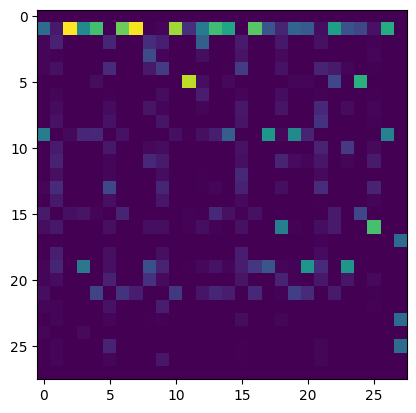

In [15]:

import matplotlib.pyplot as plt

plt.imshow(model[STOI['.']])

In [15]:

def sample(model: torch.tensor, context: str) -> str:
    return ITOS[
        torch.multinomial(
            model[STOI[context], :],
            replacement=True,
            num_samples=1
        ).item()
    ]

print(sample(model, '.'))

P


In [16]:

def generate(model: torch.tensor, n: int) -> list[str]:
    names = []
    for i in range(n):
        result = ""
        token = "."
        while True:
            token = sample(model, token)
            if token == '.':
                break

            result += token

        names.append(result)
    return names

generate(model, 5)

['BOO SERAF',
 'BE SHAN EKHELSAUMI KATAN',
 'WA HAR DEN',
 'PL',
 'TALEMA KISAN SASHARADAPUR TARO']

In [17]:
import math

def nll_loss(names: list[str]) -> float:
    logprobs = 0
    count = 0
    for name in names:
        for c1, c2, c_next in zip(name, name[1:], name[2:]):
            logprobs += math.log(model[STOI[c1], STOI[c2], STOI[c_next]])
            count += 1

    return -logprobs / count

nll_loss(MOVIES)

1.8170285469177778

In [ ]:
from typing import Tuple

def training_set() -> Tuple[torch.Tensor, torch.Tensor]:
    xs, ys = [], []
    for name in MOVIES:
        chars = ['.'] + list(name) + ['.']
        for c1, c2 in zip(chars, chars[1:]):
            ix1 = STOI[c1]
            ix2 = STOI[c2]
            xs.append(ix1)
            ys.append(ix2)

    return torch.tensor(xs), torch.tensor(ys) 
    
X, Y = training_set()
print(X.shape, Y.shape)

torch.Size([167136]) torch.Size([167136])


In [48]:
import torch.nn.functional as F

def train() -> Tuple[torch.tensor, float]:
    "Trains the neural net and returns the weight matrix and the loss"

    g = torch.Generator().manual_seed(2147483647)
    Xenc = F.one_hot(X, num_classes=len(VOCAB)).float()
    N = X.nelement()
    W = torch.randn((len(VOCAB), len(VOCAB)), generator=g, requires_grad=True)
    loss = 0

    def forward():
        logits = Xenc @ W
        # the two lines below are "softmax"
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True) 
        return -probs[torch.arange(N), Y].log().mean()

    for k in range(100):
        loss = forward()
        if k % 10 == 0:
            print(f"loss = {loss}")
   
        W.grad = None
        loss.backward()
        W.data += -100 * W.grad

    return W, loss


In [49]:
W, loss = train()

loss = 3.791078805923462
loss = 2.6271109580993652
loss = 2.5731208324432373
loss = 2.554370403289795
loss = 2.5453529357910156
loss = 2.5399816036224365
loss = 2.536348581314087
loss = 2.5337917804718018
loss = 2.531855344772339
loss = 2.530343532562256
